In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Program Files\Python312\python.exe -m pip install --upgrade pip


In [34]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [35]:
# Getting into the directory folder of the monkey pictures
os.listdir('./training/training')

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [36]:
# Setting the path
training_dataset_path = './training/training'
test_dataset_path = './validation/validation'

In [37]:
# Declaring the mean and std variables
mean = [0.4363, 0.4328, 0.3291] # Got the mean from the function "get_mean_and_std"
std = [0.2129, 0.2075, 0.2037] # Got the std from the function "get_mean_and_std"

# Transforming the training and test dataset
training_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224
    transforms.RandomHorizontalFlip(), # Randomly flip images horizontally, training becomes less bias
    transforms.RandomRotation(10), # Randomly rotates the images 10 degrees
    transforms.ToTensor(), # Convert images to PyTorch Tensors
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)) # Normalize the dataset to improve the performance of the model
]) # Resizing the dataset to make them all the same size

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224
    transforms.ToTensor(), # Convert images to PyTorch Tensors
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)) # Normalize the dataset to improve the performance of the model
]) # Resizing the dataset to make them all the same size

In [38]:
train_dataset = torchvision.datasets.ImageFolder(root = training_dataset_path, transform = training_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_dataset_path, transform = test_transforms)

In [39]:
# Just to see how the images look and how they are being transformed
def show_transformed_images(dataset):
    # Create a DataLoader to sample 6 images from the dataset randomly
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    # Grab the first batch from the DataLoader
    batch = next(iter(loader))
    images, labels = batch
    
    # Create a grid of images (2 rows x 3 columns if nrows = 3)
    grid = torchvision.utils.make_grid(images, nrow = 3)

    # Create a figure and set its size (11 x 11 inches)
    plt.figure(figsize=(11,11))

    # Convert image from (C, H, W) to (H, W,C ) for display
    plt.imshow(np.transpose(grid, (1, 2, 0)))

    # Shows the labels associated with the images in the batch
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0857832..3.274317].


labels:  tensor([1, 8, 3, 0, 1, 9])


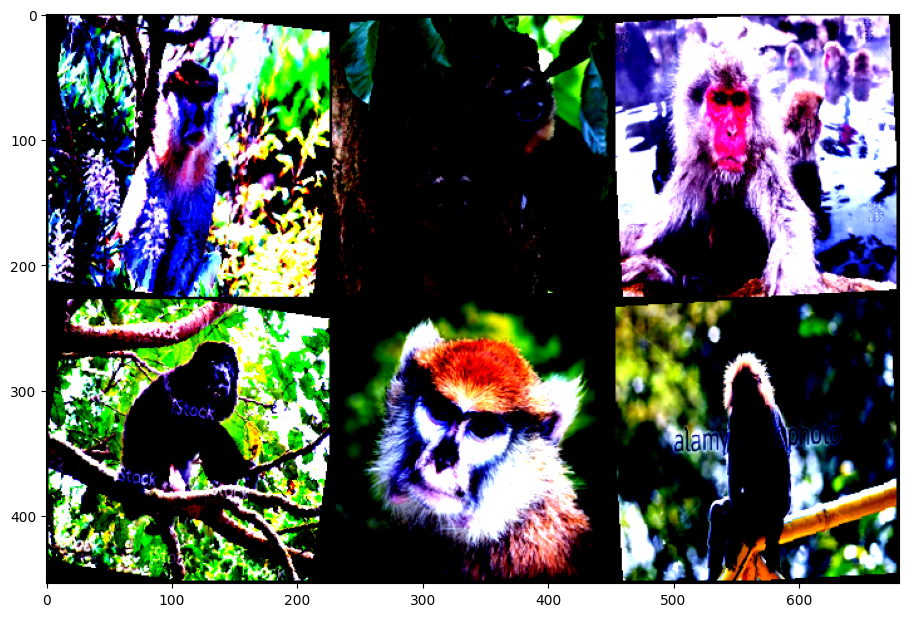

In [41]:
# Print the results
show_transformed_images(train_dataset)

In [56]:
# Mini-Batch Gradient Descent Algorithm
train_loader  = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=32, shuffle=True) # Batch = 32, each batch will contain 32 images
test_loader  = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=32, shuffle=False)


In [25]:
# Calculates the mean and std of each batch
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_image_count = 0
    # Iterate through all of the batches
    for images, _ in loader:
        # Get the number of images in the current batch
        image_count_in_a_batch = images.size(0)
        # Reshape each image
        images = images.view(image_count_in_a_batch, images.size(1), -1)     
        # Update the mean, std, total_image_count values
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_image_count += image_count_in_a_batch

    # Average Mean and Std values
    mean /= total_image_count
    std /= total_image_count

    return mean, std
        

In [26]:
get_mean_and_std(train_loader)

(tensor([0.4363, 0.4328, 0.3291]), tensor([0.2129, 0.2075, 0.2037]))

In [ ]:
# Check if a GPU (CUDA) is available and select the appropriate device
# This helps speed up neural network training if a GPU is present
def set_device():
    if torch.cuda.is_available():
        # Check if CUDA is available on the system
        dev = "cuda:0"
    else:
        # Fallback to CPU if no GPU is available
        dev = "cpu"
    return torch.device(dev)

In [52]:
# ResNet18 Model
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Load ResNet18 without pretrained weights, pretrained doesn't exist in newer versions
# Using weights instead of it
resnet18_model = models.resnet18(weights=None)

# Get the number of input features to the final fully connected layer
num_ftrs = resnet18_model.fc.in_features

# Define how many output classes the dataset has
number_of_classes = 10

# Replace the final fully connected layer with one for the number of classes
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)

# Move model to GPU if available, else CPU
device = set_device()
resnet18_model = resnet18_model.to(device)

# Controls the error, the loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer (SGD with learning rate, momentum, and weight decay)
# Parameters = tells the optimizer which parameters the model's weight and biases to update
# Learning Rate (lr) = Controls how big each step is during training
# Momentum = Helps speed up and smooth training
# Weight_decay = Helps prevent overfitting by keeping the model weights small
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

In [59]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    # Set the device
    device = set_device()

    for epoch in range(n_epochs):
        # What the current Epoch number is
        print("Epoch number %d " % (epoch + 1))
        # Set model to training mode
        model.train()
        running_loss = 0.0 # Accumulates total loss for the epoch
        running_correct = 0.0 # Counts correct predictions
        total = 0 # Total number of images seen

        # Loop through all batches in the training data
        for data in train_loader:
            # Move images and labels to the same device as the model
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # Add number of samples in this batch
            total += labels.size(0)

            # Clear any previously stored gradients
            optimizer.zero_grad()

            # Compute model output
            outputs = model(images)

            # Get predicted class per image
            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels) # Calculate loss between predictions and true labels

            loss.backward() # Backward Pass: compute gradients

            optimizer.step() # Update model weights using gradients

            # Accumulate batch loss
            running_loss += loss.item()
            # Count correct predictions
            running_correct += (labels==predicted).sum().item()
        
        # Computer average loss and accuracy for the epoch
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        # Print metrics for this epoch
        print("  - Training Dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
              % (running_correct, total, epoch_acc, epoch_loss))
        
        evaluate_model_on_test_set(model, test_loader)

        print('Finished')
        return model



In [58]:
def evaluate_model_on_test_set(model, test_loader):
    print('Hello, Testing')